In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool
import math as m
import numpy as np
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv(r'C:\Users\User\OneDrive\Untitled Folder\Testing problems\Magnit\data_regression_for_task.csv')

# Анализ датафрейма

In [3]:
# Смотрю свойства датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128355 entries, 0 to 128354
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   YEAR           128355 non-null  int64  
 1   MONTH          128355 non-null  int64  
 2   CONTRAGENT     128331 non-null  object 
 3   ARTICLE_CODE   128355 non-null  object 
 4   ARTICLE_NAME   128355 non-null  object 
 5   ARTICLE_GROUP  128354 non-null  object 
 6   SALES          128355 non-null  float64
 7   STORE_SALES    128355 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 7.8+ MB


In [4]:
df.describe()

,YEAR,MONTH,SALES,STORE_SALES
count,128355.000000,128355.000000,1.283550e+05,128355.000000
mean,2017.206030,7.079303,6.563037e+03,22.624213
std,0.404454,3.645826,2.892494e+04,239.693277
min,2017.000000,1.000000,-6.490000e+03,-4996.000000
25%,2017.000000,5.000000,0.000000e+00,0.000000
50%,2017.000000,8.000000,3.300000e+02,1.000000
75%,2017.000000,10.000000,3.250000e+03,4.000000
max,2018.000000,12.000000,1.616600e+06,16271.750000


In [5]:
# Работа с пропусками
df.isna().sum()

YEAR              0
MONTH             0
CONTRAGENT       24
ARTICLE_CODE      0
ARTICLE_NAME      0
ARTICLE_GROUP     1
SALES             0
STORE_SALES       0
dtype: int64

In [6]:
df['CONTRAGENT'].value_counts(dropna = False)
# Можно заполнить, как 'NO DATA'
df['CONTRAGENT'].fillna('NO DATA', inplace = True)

In [7]:
# Что там за один nan в группе?
df['ARTICLE_GROUP'].value_counts(dropna = False)
# Поиск в гугле говорит, что это вино, заполню, как WINE
df[df['ARTICLE_GROUP'].isna()]

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES
66439,2017,10,REPUBLIC NATIONAL DISTRIBUTING CO,347939,FONTANAFREDDA BAROLO SILVER LABEL 750 ML,NaN,0.0,1.0


In [8]:
df['ARTICLE_GROUP'].fillna('WINE',inplace = True)

In [9]:
for item in df:
    print('Уникальных значений в столбце {}:{}'.format(item,len(df[item].value_counts(dropna = False))))


Уникальных значений в столбце YEAR:2
Уникальных значений в столбце MONTH:10
Уникальных значений в столбце CONTRAGENT:334
Уникальных значений в столбце ARTICLE_CODE:23556
Уникальных значений в столбце ARTICLE_NAME:23624
Уникальных значений в столбце ARTICLE_GROUP:8
Уникальных значений в столбце SALES:7019
Уникальных значений в столбце STORE_SALES:2518


# Обработка датафрейма для визуализации

In [10]:
# Добавлю столбец с общим количеством месяцев, чтобы наглядно продемонстрировать разницу между годами.
df['TOTAL_MONTH'] = df['MONTH']
df.loc[df['YEAR']==2018, 'TOTAL_MONTH'] = df.loc[df['YEAR']==2018, 'TOTAL_MONTH'].apply(lambda x: x+12)

In [11]:
#Функция отрисовки ежемесячных графиков.

def df_plot(df,group,what,agg,xlabel,ylabel,title):
    data = df.groupby(group)[what].agg(agg)
    f, ax = plt.subplots(figsize=(20, 6))
    ax = sns.barplot(data.keys(),data,color = '#FAC00F')
    ax.set_xticklabels(categories,{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.set_yticklabels(ax.get_yticks(),{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.tick_params(axis='x', rotation=70)
    ax.grid(axis = 'y')
    ax.axvline(x=7.5, color='red')
    ax.text(0.35*len(data.keys()), 0.75*data.max(), '2017',size = '20')
    ax.text(0.825*len(data.keys()), 0.75*data.max(), '2018',size = '20')
    ax.set_xlabel(xlabel,size = 20)
    ax.set_ylabel(ylabel,size = 20)
    ax.set_title(title, size = 25)
    return ax

# Ниже идет визуализация отобранных данных.

#Функция отрисовки ежемесячных графиков.

def df_plot_2(df,group,what,agg,xlabel,ylabel,title):
    data = df.groupby(group)[what].agg(agg)
    data.sort_values(inplace = True)
    data = data[-4:]
    f, ax = plt.subplots(figsize=(20, 6))
    ax = sns.barplot(data.keys(),data,color = '#FAC00F')
    ax.set_xticklabels(data.keys(),{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.set_yticklabels(ax.get_yticks(),{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.tick_params(axis='x', rotation=70)
    ax.grid(axis = 'y')
    ax.set_xlabel(xlabel,size = 20)
    ax.set_ylabel(ylabel,size = 20)
    ax.set_title(title, size = 25)
    return ax

# Ниже идет визуализация отобранных данных.

In [12]:
categories=['Апр','Май','Июн', 'Авг', 'Сен', 'Окт', 'Ноя','Дек','Янв', 'Фев']

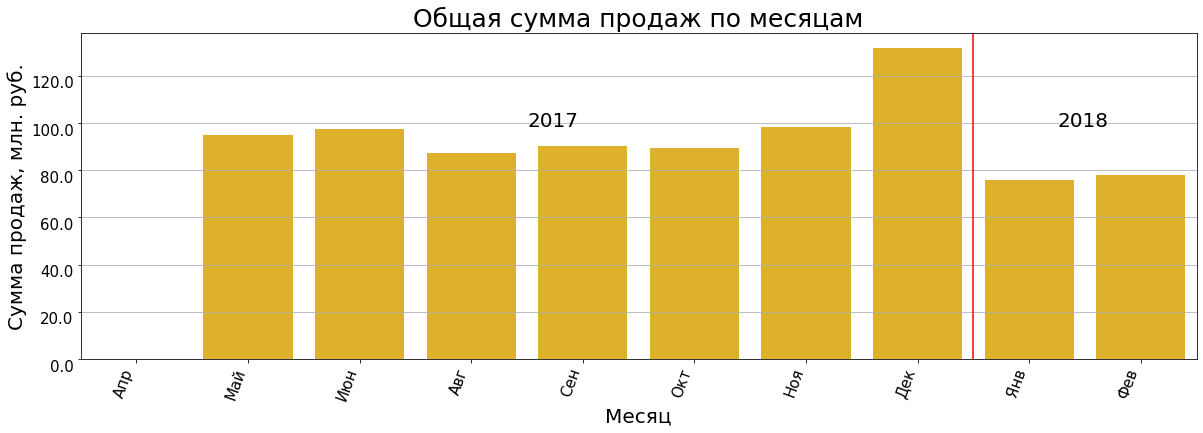

In [13]:
qplot = df_plot(df,'TOTAL_MONTH','SALES','sum','Месяц','Сумма продаж, млн. руб.','Общая сумма продаж по месяцам')
qplot.set_yticklabels(qplot.get_yticks()/1000000,{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
qplot

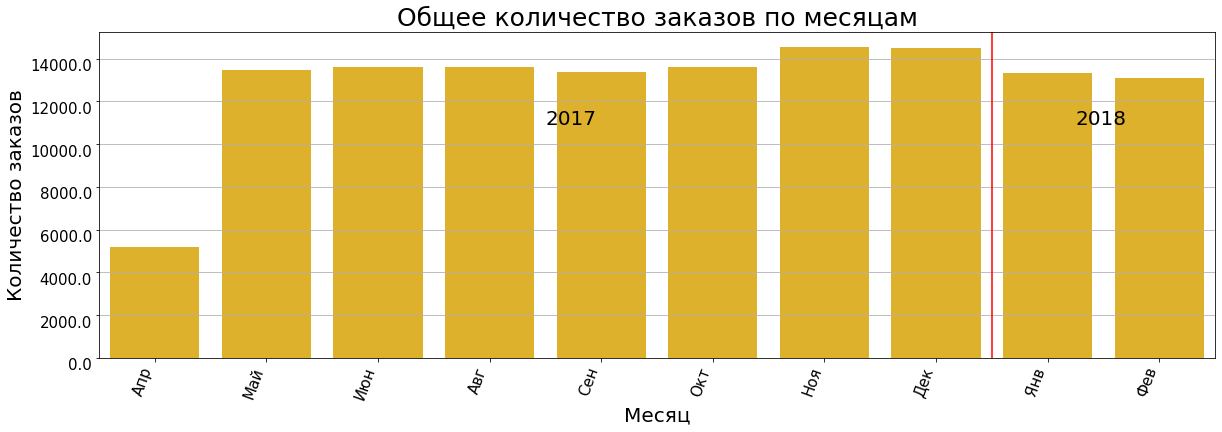

In [14]:
aplot = df_plot(df,'TOTAL_MONTH','SALES','count','Месяц','Количество заказов','Общее количество заказов по месяцам')

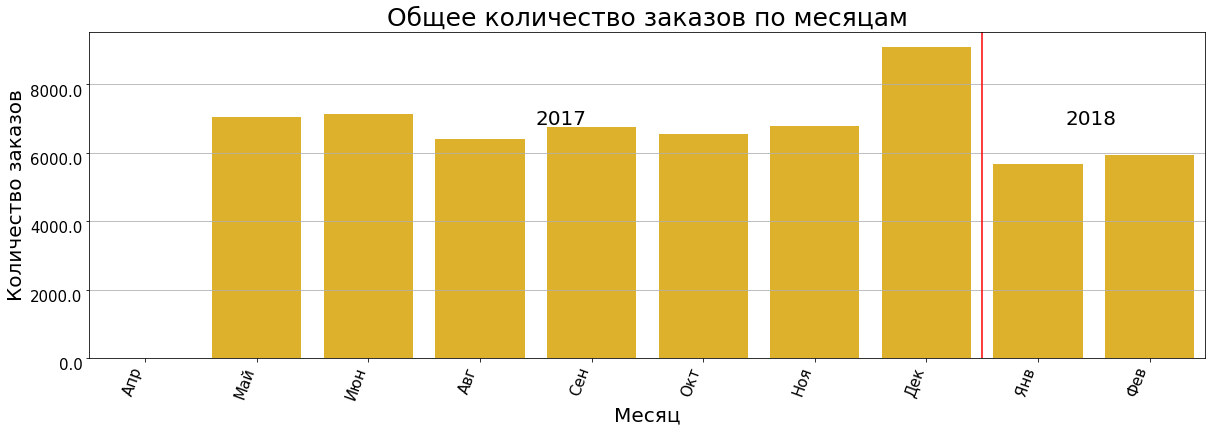

In [15]:
mplot = df_plot(df,'TOTAL_MONTH','SALES','mean','Месяц','Количество заказов','Общее количество заказов по месяцам')

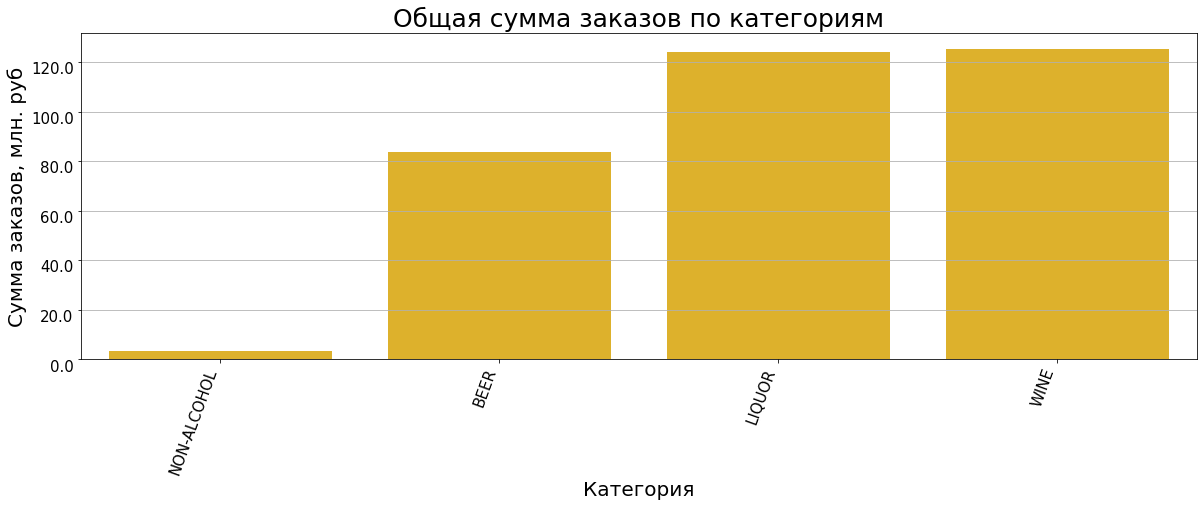

In [16]:
cat_plot = df_plot_2(df,'ARTICLE_GROUP','SALES','sum','Категория','Сумма заказов, млн. руб','Общая сумма заказов по категориям')
cat_plot.set_yticklabels(qplot.get_yticks()/1000000,
    {'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
cat_plot

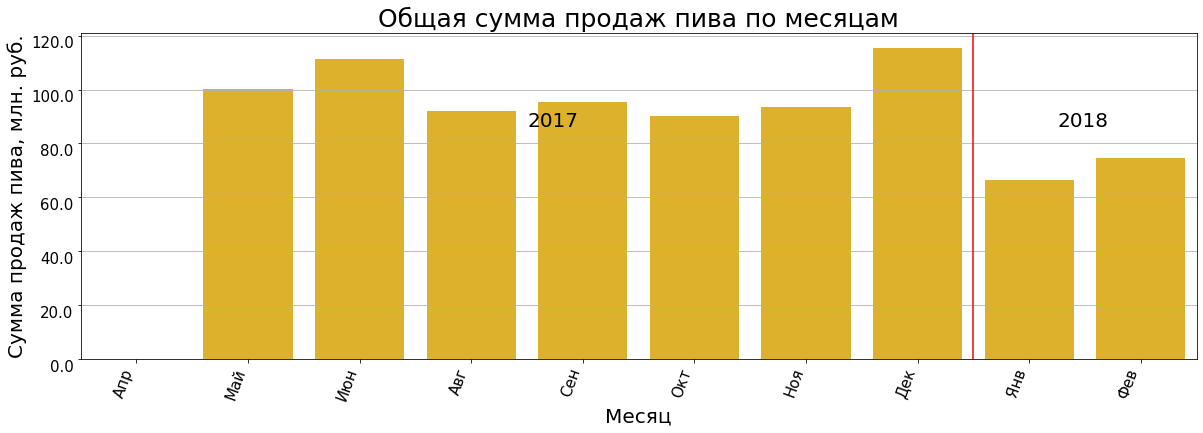

In [17]:
bplot = df_plot(df[df['ARTICLE_GROUP']=='BEER'],'TOTAL_MONTH','SALES','sum','Месяц','Сумма продаж пива, млн. руб.','Общая сумма продаж пива по месяцам')
bplot.set_yticklabels(qplot.get_yticks()/1000000,{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
bplot

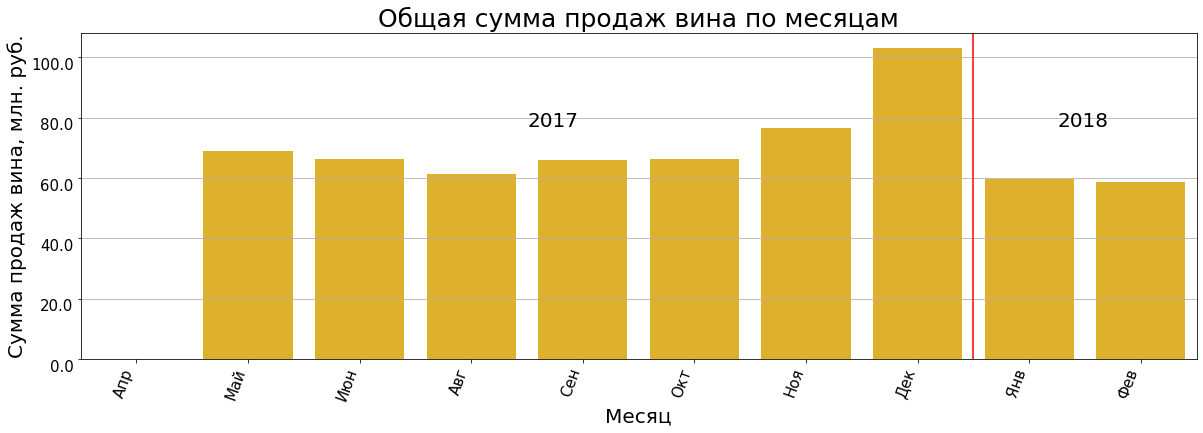

In [18]:
wplot = df_plot(df[df['ARTICLE_GROUP']=='WINE'],'TOTAL_MONTH','SALES','sum','Месяц','Сумма продаж вина, млн. руб.','Общая сумма продаж вина по месяцам')
wplot.set_yticklabels(qplot.get_yticks()/1000000,{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
wplot

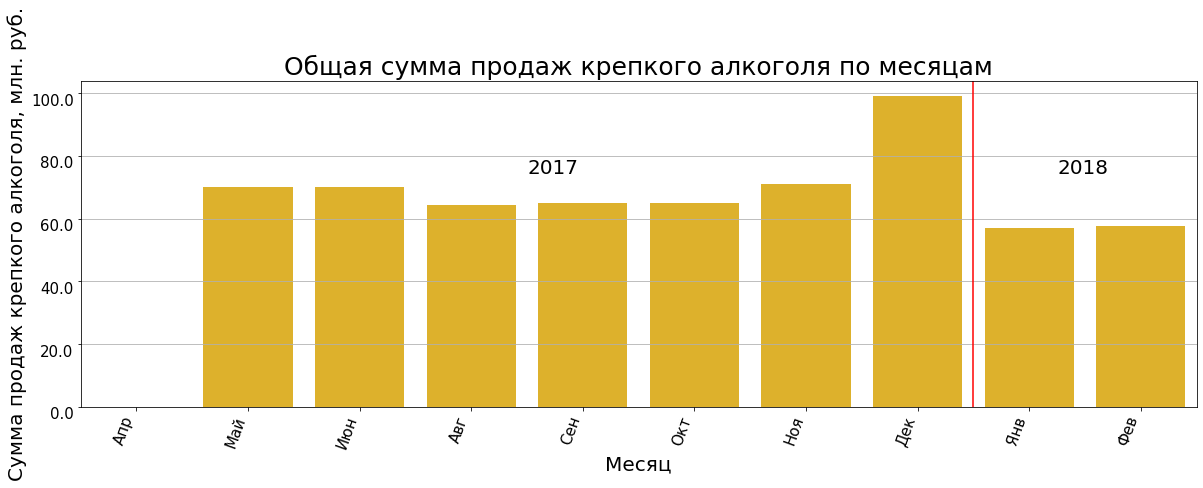

In [19]:
lplot = df_plot(df[df['ARTICLE_GROUP']=='LIQUOR'],'TOTAL_MONTH','SALES','sum','Месяц','Сумма продаж крепкого алкоголя, млн. руб.','Общая сумма продаж крепкого алкоголя по месяцам')
lplot.set_yticklabels(qplot.get_yticks()/1000000,{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
lplot

Text(0.5, 1.0, 'Топ 10 самых продаваемых товаров')

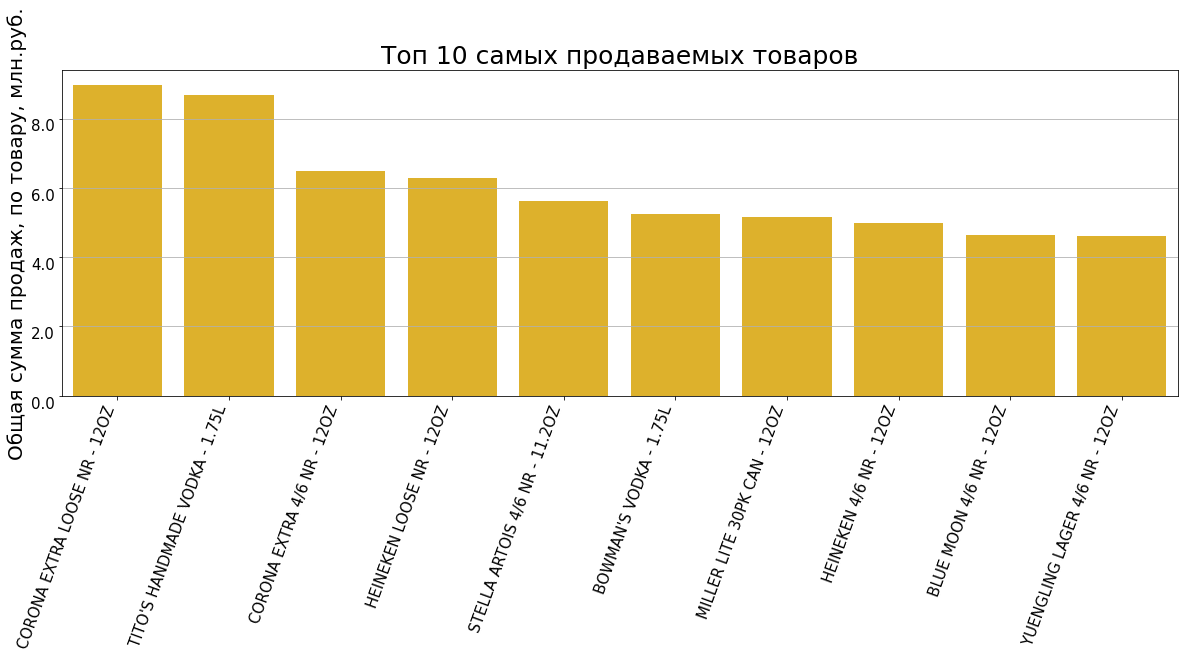

In [20]:
art_sum = df.groupby('ARTICLE_NAME')['SALES'].sum()
art_sum = art_sum.sort_values(ascending = False)[0:10]
f, ax = plt.subplots(figsize=(20, 6))
ax = sns.barplot(art_sum.keys(),art_sum,color = '#FAC00F')
ax.set_xticklabels(art_sum.keys(),{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
ax.set_yticklabels(ax.get_yticks()/1000000,{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
ax.tick_params(axis='x', rotation=70)
ax.grid(axis = 'y')
ax.set_xlabel('')
ax.set_ylabel('Общая сумма продаж, по товару, млн.руб.',size = 20)
ax.set_title('Топ 10 самых продаваемых товаров', size = 25)


# Обучение регрессионной модели


In [21]:
df['SALES'] = df['SALES'].apply(lambda x: m.log(abs(x+1)))

In [22]:
df['STORE_SALES'] = df['STORE_SALES'].apply(lambda x: m.log(abs(x+0.1)))

In [23]:
df

,YEAR,MONTH,CONTRAGENT,ARTICLE_CODE,ARTICLE_NAME,ARTICLE_GROUP,SALES,STORE_SALES,TOTAL_MONTH
0,2017,4,ROYAL WINE CORP,100200,GAMLA CAB - 750ML,WINE,0.000000,-2.302585,4
1,2017,4,SANTA MARGHERITA USA INC,100749,SANTA MARGHERITA P/GRIG ALTO - 375ML,WINE,0.000000,-2.302585,4
2,2017,4,JIM BEAM BRANDS CO,10103,KNOB CREEK BOURBON 9YR - 100P - 375ML,LIQUOR,0.000000,-2.302585,4
3,2017,4,HEAVEN HILL DISTILLERIES INC,10120,J W DANT BOURBON 100P - 1.75L,LIQUOR,0.000000,-2.302585,4
4,2017,4,ROYAL WINE CORP,101664,RAMON CORDOVA RIOJA - 750ML,WINE,0.000000,-2.302585,4
...,...,...,...,...,...,...,...,...,...
128350,2018,2,ANHEUSER BUSCH INC,9997,HOEGAARDEN 4/6NR - 12OZ,BEER,11.104371,5.357058,14
128351,2018,2,COASTAL BREWING COMPANY LLC,99970,DOMINION OAK BARREL STOUT 4/6 NR - 12OZ,BEER,9.113940,3.558201,14
128352,2018,2,BOSTON BEER CORPORATION,99988,SAM ADAMS COLD SNAP 1/6 KG,KEGS,0.000000,3.468856,14
128353,2018,2,NO DATA,BC,BEER CREDIT,REF,0.000000,3.552487,14


In [24]:
# Определяемая метрика. По виду это метритка MAPE - Mean Absolute percentage error.
def metric(y_true, y_pred):
    
    return np.sum(np.abs(y_true - y_pred)) / np.sum(y_pred) * 100

In [25]:
cat_f = ['CONTRAGENT','ARTICLE_CODE','ARTICLE_NAME','ARTICLE_GROUP']
# Кодирую категориальные переменные
result = df.copy()
for col in cat_f:
    result[col] = result[col].astype('category').cat.codes

In [26]:
X = result[result['TOTAL_MONTH']!= 14].drop('SALES', axis = 1)
y = result[result['TOTAL_MONTH']!= 14]['SALES']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, shuffle=True, random_state=42)

In [29]:
# Для прогнозирования будем использловать регрессор CatBoostRegressor с подбором параметров через GridsearchCV.

# grid = {'learning_rate':[0.1,0.5,0.7],
#         'l2_leaf_reg':[3,6,9],
#         }
# {'l2_leaf_reg': 9, 'learning_rate': 0.1}



model = CatBoostRegressor(iterations = 1000,
                          learning_rate=0.1,
                          l2_leaf_reg = 9,
                          random_seed = 42,
                          eval_metric='MAPE',
                         )


# catgrid = GridSearchCV(model,grid)

model.fit(X_train, y_train,
         cat_features=cat_f,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.9100303	test: 1.9012093	best: 1.9012093 (0)	total: 176ms	remaining: 2m 55s
500:	learn: 0.6406116	test: 0.5373559	best: 0.5196163 (391)	total: 25.8s	remaining: 25.7s
999:	learn: 0.6142885	test: 0.5379840	best: 0.5196163 (391)	total: 1m 2s	remaining: 0us

bestTest = 0.5196163447
bestIteration = 391

Shrink model to first 392 iterations.


In [31]:
X_sub = result[result['TOTAL_MONTH'] == 14].drop('SALES', axis = 1)
y_sub = result[result['TOTAL_MONTH'] == 14]['SALES']

In [32]:
y_pred = model.predict(X_sub)

In [33]:
print(f'Значение искомой метрики: {round(metric(y_sub, y_pred),3)}%')

Значение искомой метрики: 28.591%


In [ ]:
# Результат можно немного улучшить, увеличив диапазон для подбора параметров через GridSearchCV.